In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost
from sklearn import model_selection
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score, precision_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Reading from our CSV file (we have added an 'Error' header for the last column to make processing easier):

In [2]:
df = pd.read_csv('finantier_data_technical_test_dataset.csv')

# Error column handling
df['Error'].replace(np.nan, 'No', inplace = True)
df['Error'].replace('error_error', np.nan, inplace = True)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default,Error
0,4808-GHDJN,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,No
2,5575-GNVDE,Male,0.0,No,No,34.0,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,NaN
3,3668-QPYBK,Male,0.0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,No
4,7795-CFOCW,Male,0.0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,No


Now we check the data types contained in the columns of our dataset:

In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen       float64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Default              object
Error                object
dtype: object

Noticing that total charges is of type object (likely string), we need to convert it to float type (or any relevant numeric type) and then check for null values (if not TotalCharges would have been read as float in the first place):

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

df.isnull().sum()

customerID           4
gender               4
SeniorCitizen        5
Partner              5
Dependents           5
tenure               5
PhoneService         5
MultipleLines        5
InternetService      5
OnlineSecurity       5
OnlineBackup         5
DeviceProtection     5
TechSupport          5
StreamingTV          5
StreamingMovies      5
Contract             5
PaperlessBilling     5
PaymentMethod        5
MonthlyCharges       5
TotalCharges        16
Default              5
Error                4
dtype: int64

We see multiple null values in each row, which we can easily remove using dropna function. We also need to remove the customerID and error columns as they are not relevant to our processing:

In [6]:
# Remove all null values
df.dropna(inplace = True)

# Remove error and customerID column
df.drop(labels = ['customerID', 'Error'], axis = 1, inplace = True)

df.isnull().sum()
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default
1,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
3,Male,0.0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
4,Male,0.0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
5,Female,0.0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
6,Female,0.0,No,No,8.0,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes


Now we have no more null values and our irrelevant columns have been removed! Thus the data cleaning has been completed. We now need to perform data encoding on the various columns. We can label encode binary columns and use `pd.dummies()` function to one hot encode all the other columns.

In [7]:
# We let not having defaulted be a value of 1 while defaulting be a value of 0
# df['Default'] = df['Default'].map({'Yes': 0, 'No': 1})

# Perform label encoding on binary columns
to_label_encode = ['gender',
                   'Partner',
                   'Dependents',
                   'PhoneService',
                   'Default',
                   'PaperlessBilling',
                   'SeniorCitizen'
                   ]

df[to_label_encode] = df[to_label_encode].apply(LabelEncoder().fit_transform)

df.head()

# Perform one-hot encoding on the rest of our data

df_dummies = pd.get_dummies(df)
df_dummies.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Default,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1,0,0,1,0,1.0,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
3,1,0,0,0,2.0,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
4,1,0,0,0,45.0,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
5,0,0,0,0,2.0,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0
6,0,0,0,0,8.0,1,1,99.65,820.50,1,...,0,0,1,1,0,0,0,0,1,0


We now perform min-max scaling on our numerical columns to scale them between 1 and 0:

In [8]:
df_scaled = df_dummies

features_mms = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(df[features_mms].apply(max))
df_scaled[features_mms] = MinMaxScaler().fit_transform(df_scaled[features_mms])
df_scaled.head()

tenure              72.00
MonthlyCharges     118.75
TotalCharges      8684.80
dtype: float64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Default,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1,0,0,1,0,0.000000,0,1,0.115423,0.001275,0,...,1,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0.014085,1,1,0.354229,0.010310,1,...,1,0,0,1,0,0,0,0,0,1
4,1,0,0,0,0.619718,0,0,0.239303,0.210241,0,...,1,0,0,0,1,0,1,0,0,0
5,0,0,0,0,0.014085,1,1,0.521891,0.015330,1,...,1,0,0,1,0,0,0,0,1,0
6,0,0,0,0,0.098592,1,1,0.809950,0.092511,1,...,0,0,1,1,0,0,0,0,1,0


Now, we check all the column headers in our data (this will be useful when using our model for an API endpoint)

In [9]:
df_scaled.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Default', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMet

We now need to check the skew of the data, which we can find using the average of the default column:

In [10]:
sum(df_scaled['Default'])/len(df_scaled['Default'])

0.2658984208279983

We see that our data is largely skewed towards people who do not default on their payments. We thus need to stratify our training/testing data as such. With our feature engineering complete, we can now split our testing and training data:

In [11]:
# Applying sklearn's splitter

X = df_scaled.drop(labels = 'Default', axis = 1).values
y = df_scaled['Default'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

Now we are ready to train our preliminary model. We are using XGBoost to train our data here, which although is a ML model that can handle tabular data, performs better than most deep learning models such as tabnet etc.

In [12]:
cls_weight = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train)

pre_xgb_clf = xgboost.XGBClassifier(eval_metric = 'logloss', use_label_encoder = False, random_state = 0, scale_pos_weight = cls_weight, n_jobs = -1)

pre_xgb_clf.fit(X_train,
            y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.7596291012838803,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Great! We have a trained model - now let us look at the confusion matrix of how it performs on the test data as well as calculate its accuracy and f1-scores. Here, 1 refers to a prediction of not defaulter while 0 refers to a prediction of defaulter.

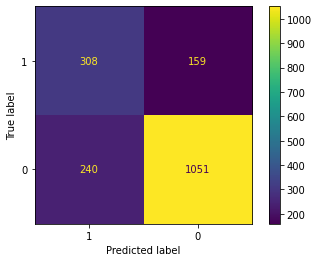

The resultant f1-score for defaulting is: 0.6068965517241379
The resultant f1-score for not defaulting is: 0.8404638144742103
The resultant accuracy is: 0.773037542662116
The resultant precision is: 0.5620437956204379


In [13]:
y_pred = pre_xgb_clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels = [1,0])
plt.show()

pre_f_score = f1_score(y_test, y_pred)
print(f"The resultant f1-score for defaulting is: {pre_f_score}")
pre_f_score_def = f1_score(y_test, y_pred, pos_label=0)
print(f"The resultant f1-score for not defaulting is: {pre_f_score_def}")
pre_accuracy = accuracy_score(y_test, y_pred)
print(f"The resultant accuracy is: {pre_accuracy}")
pre_precision = precision_score(y_test,y_pred)
print(f"The resultant precision is: {pre_precision}")

A f-score of 60.9% for predicting if a user will default. However, predicting whether the user will NOT default has a much btter f1-score of 84.0%. Our overall accuracy stands at about 77.3 and our precision at 56.2%. We will now try to optimise our parameters using cross validation and grid search techniques.

In [14]:
# round_1 = {
#     'max_depth' : [3,4,5],
#     'learning_rate' : [0.1, 0.5 , 1],
#     'gamma' : [0, 0.5, 1.0],
#     'reg_lambda' : [10, 20, 50],
# }

# optimal_params = model_selection.GridSearchCV(
#     estimator = xgboost.XGBClassifier(use_label_encoder = False,
#                                       random_state = 0,
#                                       scale_pos_weight = cls_weight,
#                                       n_jobs = -1,
#                                       eval_metric = 'logloss'),
#     param_grid = round_1,
#     scoring = 'roc_auc',
#     verbose = 0,
#     n_jobs = 10,
#     cv = 3
# )

# optimal_params.fit(X_train, y_train)

# print(optimal_params.best_params_)

The optimal parameters given from the first run are:
`{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 50}`
We now fine tune the parameters that returned on either extreme of our round 1 parameter options.

In [15]:
# round_2 = {
#     'max_depth' : [3],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0.5],
#     'reg_lambda': [50, 100, 200]
# }

# optimal_params = model_selection.GridSearchCV(
#     estimator = xgboost.XGBClassifier(use_label_encoder = False,
#                                       random_state = 0,
#                                       scale_pos_weight = cls_weight,
#                                       n_jobs = -1,
#                                       eval_metric = 'logloss'),
#     param_grid = round_1,
#     scoring = 'roc_auc',
#     verbose = 0,
#     n_jobs = 10,
#     cv = 3
# )

# optimal_params.fit(X_train, y_train)

# print(optimal_params.best_params_)

Our output from the second run gives the final optimised hyperparameters for our model:
`{max_depth : 3, learning_rate : 0.1, gamma: 0.5, reg_lambda : 50}`

In [16]:
xgb_clf = xgboost.XGBClassifier(use_label_encoder = False,
                                random_state = 0,
                                scale_pos_weight = cls_weight,
                                n_jobs = -1,
                                gamma = 0.5,
                                learning_rate = 0.1,
                                max_depth = 3,
                                reg_lambda = 50,
                                eval_metric = 'logloss')

xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=50, scale_pos_weight=2.7596291012838803,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

With our final model, let us calculate the metrics.

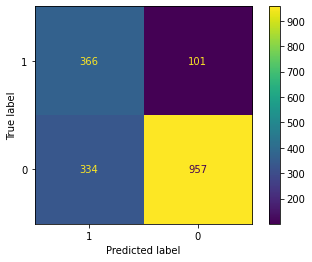

The resultant f1-score for defaulting is: 0.6272493573264782
The resultant f1-score for not defaulting is: 0.8148148148148148
The resultant accuracy is: 0.7525597269624573
The resultant precision is: 0.5228571428571429


In [17]:
y_pred = xgb_clf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels = [1,0])
plt.show()

f_score = f1_score(y_test, y_pred)
print(f"The resultant f1-score for defaulting is: {f_score}")
f_score_def = f1_score(y_test, y_pred, pos_label=0)
print(f"The resultant f1-score for not defaulting is: {f_score_def}")
accuracy = accuracy_score(y_test, y_pred)
print(f"The resultant accuracy is: {accuracy}")
precision = precision_score(y_test,y_pred)
print(f"The resultant precision is: {precision}")

We can now compare to see how much our new model has improved!

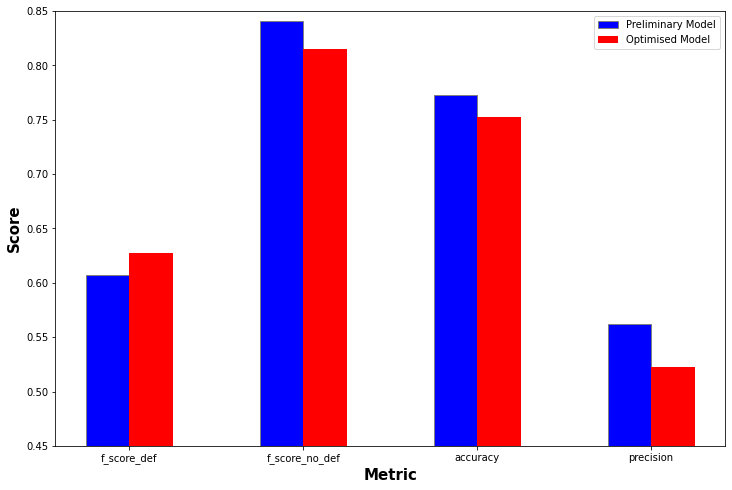

In [18]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

pre_data = [pre_f_score, pre_f_score_def, pre_accuracy, pre_precision]
data = [f_score, f_score_def, accuracy, precision]

# Set position of bar on X axis
br1 = np.arange(len(pre_data))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, pre_data, color ='b', width = barWidth,
        edgecolor ='grey', label ='Preliminary Model')
plt.bar(br2, data, color ='r', width = barWidth, label ='Optimised Model')
 
# Adding Xticks
plt.xlabel('Metric', fontweight ='bold', fontsize = 15)
plt.ylabel('Score', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth/2 for r in range(len(pre_data))],
        ['f_score_def', 'f_score_no_def', 'accuracy', 'precision'])

# Adjust the y-axis to zoom in on the relevant area
ax = plt.gca()
ax.set_ylim([0.45,0.85])

plt.legend()
plt.show()


In [19]:
# Calculate percentage increase from base model
f_score_inc = (f_score - pre_f_score)/pre_f_score
f_score_def_inc = (f_score_def - pre_f_score_def)/pre_f_score_def
accuracy_inc = (accuracy - pre_accuracy)/pre_accuracy
precision_inc = (precision - pre_precision)/pre_precision

print(f"The increase in f1-score for defaulters is {f_score_inc*100}%")
print(f"The increase in f1-score for not defaulting is {f_score_def_inc*100}%")
print(f"The increase in accuracy is {accuracy_inc*100}%")
print(f"The increase in precision is {precision_inc*100}%")

The increase in f1-score for defaulters is 3.3535872867492573%
The increase in f1-score for not defaulting is -3.0517672763153243%
The increase in accuracy is -2.649006622516553%
The increase in precision is -6.972170686456389%


We can see that while our f1-score for predicting if a user will default on their telco payment has increased slightly, it has come at the cost of the other metrics. While our f1-score for defaulting improved by 3.35%, the f1-score for not defaulting decreased by 3.05%, the accuracy dropped by 2.64% and the precision dropped by 6.97%. Depending on the metric we are targetting, we can choose the relevant model as such.

Finally, we can save our model!

In [20]:
import pickle
pickle.dump(pre_xgb_clf, open("preliminary_telco_default_model.json", "wb"))
pickle.dump(xgb_clf, open("telco_default_model.json", "wb"))